In [1]:
import numpy as np
import cupy as cp
from numba import jit, prange
import timeit
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from cupyx.scipy.sparse import coo_matrix as cp_coo_matrix

In [2]:
def sv_base(mat, b):
    res = mat * b
    
def sv_cp(mat, b):
    res = mat * b
    
@jit(nopython=True, parallel=True)
def sv_nb(A, iA, jA, b):
    res = np.zeros(b.shape[0])
    for row in prange(len(iA)-1):
        for i in prange(iA[row], iA[row+1]):
            res[row] += A[i]*b[jA[i]] 
    return res
    
@jit(nopython=True, parallel=True)
def sv_nb2(A, iA, jA, b):
    res = np.zeros(b.shape[0])
    for row in prange(len(iA)-1):
        for i in range(iA[row], iA[row+1]):
            res[row] += A[i]*b[jA[i]] 
    return res

In [3]:
N = [int(8*(2**0.5)**i) for i in range(28)]
methods = ["sv_base", "sv_cp", "sv_nb", "sv_nb2"]
K = len(methods)
funcs = [sv_base, sv_cp, sv_nb, sv_nb2]
masks = [1, 1, 1, 1]
groups = [0, 0, 0, 0]
T = [[] for i in range(K)]
deg = 40
for n in N:
    print("Start with size:", n)
    row, col = np.random.randint(0, n, (2, n*deg))
    data = np.random.rand(n*deg)
    b = np.random.rand(n)
    cb = cp.array(b)
    mat = coo_matrix((data,(row, col)), shape=(n,n)).tocsr()
    cmat = cp_coo_matrix((cp.array(data), (cp.array(row), cp.array(col))), shape=(n,n)).tocsr()
    
    res = np.zeros(n)
    args = [(mat, b), (cmat, cb), (mat.data, mat.indptr, mat.indices, b), (mat.data, mat.indptr, mat.indices, b)]
    
    for i in range(K):
        t = %timeit -q -n 1 -r 3 -o funcs[i](*args[i])
        T[i].append(t.average*1000)

Start with size: 8
Start with size: 11
Start with size: 16
Start with size: 22
Start with size: 32
Start with size: 45
Start with size: 64
Start with size: 90
Start with size: 128
Start with size: 181
Start with size: 256
Start with size: 362
Start with size: 512
Start with size: 724
Start with size: 1024
Start with size: 1448
Start with size: 2048
Start with size: 2896
Start with size: 4096
Start with size: 5792
Start with size: 8192
Start with size: 11585
Start with size: 16384
Start with size: 23170
Start with size: 32768
Start with size: 46340
Start with size: 65536
Start with size: 92681


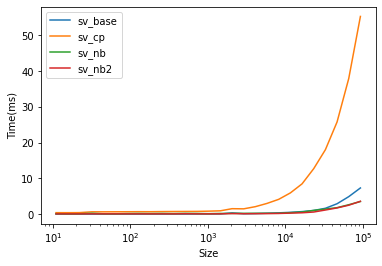

In [4]:
n_groups = max(groups)+1
fig, axs = plt.subplots(n_groups)
plt.rcParams["figure.figsize"] = (10,15)
if n_groups == 1:
    for i in range(K):
        if masks[i]:
            axs.plot(N[1:], T[i][1:], label=methods[i])
    axs.set_xlabel("Size")
    axs.set_ylabel("Time(ms)")
    axs.legend()
    axs.set_xscale('log')
else:
    for g in range(n_groups):
        for i in range(K):
            if masks[i] and groups[i] == g:
                axs[g].plot(N[1:], T[i][1:], label=methods[i])
        axs[g].set_xlabel("Size")
        axs[g].set_ylabel("Time(ms)")
        axs[g].legend()
        axs[g].set_xscale('log')
plt.show()

In [5]:
print(T)

[[0.050979999893267326, 0.00790499810439845, 0.00874733329207326, 0.0074796674501461284, 0.007889999930436412, 0.009965334659985578, 0.010586667485767975, 0.012091334307721505, 0.011413000417329991, 0.0135656652370623, 0.01625433408965667, 0.0202370004747839, 0.024759998874894034, 0.0345940000746244, 0.04265099899688115, 0.05617799979518168, 0.33818133306340314, 0.11345333283922325, 0.15911366669267105, 0.24717033375054598, 0.3629779991266939, 0.5049596669171782, 0.7113573337846901, 1.0308603341400158, 1.63601033273153, 2.9082536675559822, 4.891491000307724, 7.3217996675036074], [0.8909693339470929, 0.4133066662082759, 0.4075433328883567, 0.4241986668300039, 0.6525986670264198, 0.6501686669556269, 0.6628013337225033, 0.6715899993044635, 0.689489332823238, 0.6805889994817941, 0.7173499992253104, 0.7376913332943028, 0.7545706672923794, 0.7698846663212559, 0.834548666413563, 0.9295083339869356, 1.5254156678565778, 1.4849203325866256, 2.0926759995442503, 3.003064998968815, 4.14186433530024